In [29]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from simplexai.explainers.simplex import Simplex
import matplotlib.pyplot as plt

In [26]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [27]:
# Model 1 -- Latent Exposure
class MNISTModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)

    def latent_representation(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return x

In [ ]:
# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

In [30]:
# Create smaller subsets for corpus and test inputs
corpus_indices = np.random.choice(len(train_dataset), size=100, replace=False)
test_indices = np.random.choice(len(test_dataset), size=10, replace=False)

corpus_dataset = Subset(train_dataset, corpus_indices)
test_dataset = Subset(test_dataset, test_indices)

corpus_loader = torch.utils.data.DataLoader(corpus_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

corpus_inputs, _ = next(iter(corpus_loader))
test_inputs, _ = next(iter(test_loader))

In [31]:
model = MNISTModel1().to(device)

# Compute latent representations
corpus_inputs = corpus_inputs.to(device)
test_inputs = test_inputs.to(device)

corpus_latents = model.latent_representation(corpus_inputs).detach()
test_latents = model.latent_representation(test_inputs).detach()

In [32]:
simplex = Simplex(corpus_examples=corpus_inputs, corpus_latent_reps=corpus_latents)

# Fit SimplEx
simplex.fit(test_examples=test_inputs, test_latent_reps=test_latents, reg_factor=0)

Weight Fitting Epoch: 2000/10000 ; Error: 14.4 ; Regulator: 5.95 ; Reg Factor: 0
Weight Fitting Epoch: 4000/10000 ; Error: 12.7 ; Regulator: 2.89 ; Reg Factor: 0
Weight Fitting Epoch: 6000/10000 ; Error: 12.4 ; Regulator: 2.32 ; Reg Factor: 0
Weight Fitting Epoch: 8000/10000 ; Error: 12.4 ; Regulator: 2.2 ; Reg Factor: 0
Weight Fitting Epoch: 10000/10000 ; Error: 12.3 ; Regulator: 2.15 ; Reg Factor: 0


In [45]:
weights = simplex.weights

# Compute the Integrated Jacobian for a specific example
input_baseline = torch.zeros_like(corpus_inputs)
i = 1  # Index of the test example to explain
simplex.jacobian_projection(test_id=i, model=model, input_baseline=input_baseline)

# Decompose the test example
result = simplex.decompose(i)

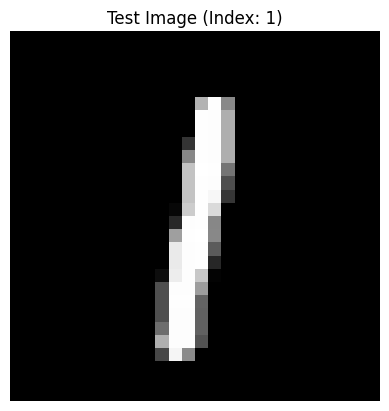

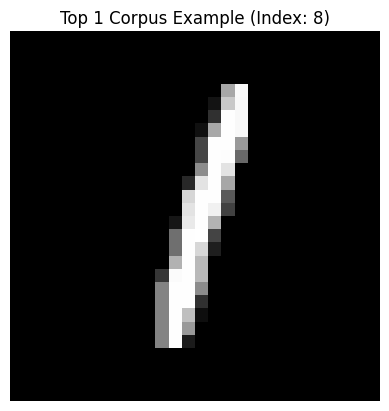

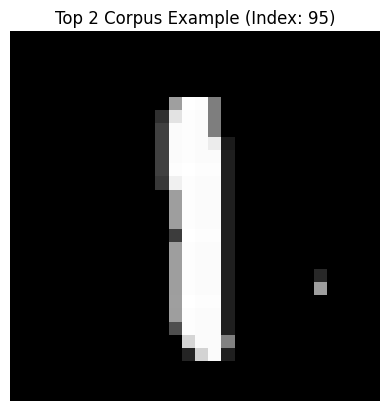

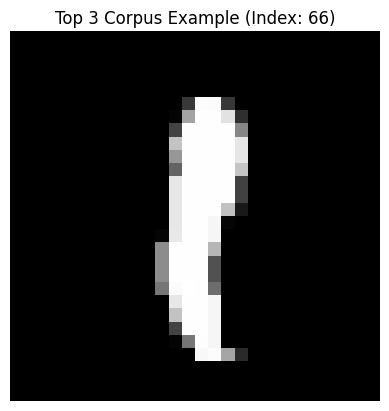

In [46]:
import matplotlib.pyplot as plt

def show_image(image, title=None):
    """Display an image with an optional title."""
    plt.imshow(image.squeeze().cpu(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize the test image and top k corpus examples
test_image = test_inputs[i]
show_image(test_image, title=f"Test Image (Index: {i})")

# Top k corpus examples
top_k_indices = weights[i].topk(k=3).indices
for rank, idx in enumerate(top_k_indices, start=1):
    show_image(corpus_inputs[idx], title=f"Top {rank} Corpus Example (Index: {idx.item()})")